In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

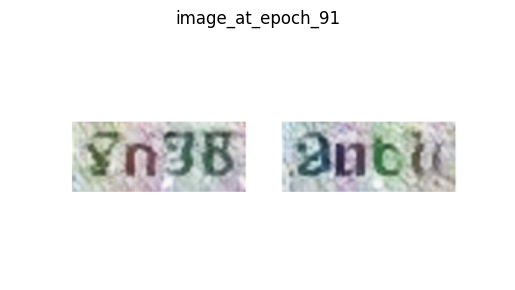

In [7]:
BAD_GENERATED_IMAGE = "/content/drive/MyDrive/Colab_Notebooks/GANS/CAPTCHA/gen_images_with_no_conditions/image_at_epoch_91.png"

# Open the image
img = Image.open(BAD_GENERATED_IMAGE)

# Plot the image
plt.figure()
plt.imshow(img)
plt.title('image_at_epoch_91')
plt.axis('off')
plt.show()

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/Colab_Notebooks/GANS/CAPTCHA/outputs"

# Get a list of all subfolders (labels) in the output directory
labels = os.listdir(OUTPUT_DIR)

# Create empty lists to store the images and labels
images = []
label_list = []

class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
               "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
               "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T",
               "U", "V", "W", "X", "Y", "Z"]

# Load and process the images and labels
for label in labels:
    label_dir = os.path.join(OUTPUT_DIR, label)
    image_files = os.listdir(label_dir)

    for image_file in image_files:
        image_path = os.path.join(label_dir, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)
        images.append(image)

        label_upper = label.upper()
        # Find the index of the uppercase label in the class_names list
        label_index = class_names.index(label_upper)
        label_list.append(label_index)

# Convert the lists to NumPy arrays
images = np.array(images, dtype=np.float32)
label_list = np.array(label_list)

images = (images - 127.5) / 127.5


# Add an additional dimension of size 1 to the images array
images = np.expand_dims(images, axis=-1)
images.shape

(30529, 28, 28, 1)

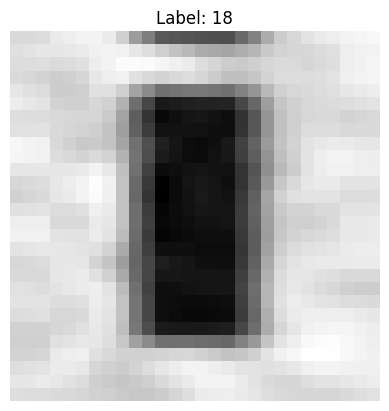

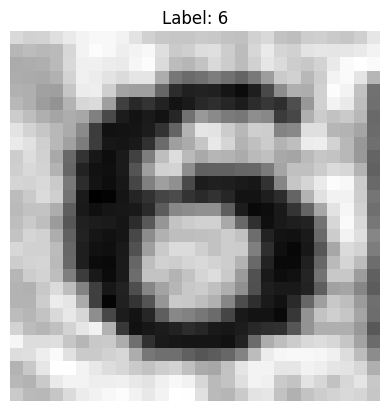

In [ ]:
num_images = len(images)

# Generate random indices for two images
random_indices = np.random.choice(num_images, size=2, replace=False)

# Select the two random images and their corresponding labels
random_images = images[random_indices]
random_labels = label_list[random_indices]

# Plot the two random images along with their labels
for i in range(2):
    image = random_images[i]
    label = random_labels[i]

    plt.imshow(image, cmap='gray')
    plt.title("Label: " + str(label))
    plt.axis('off')
    plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

In [ ]:
label_list.shape

(30529,)

In [ ]:
# Set the dimensions of the random noise vector
latent_dim = 100

# Set the number of classes (labels)
num_classes = 36

image_shape = (28, 28, 1)

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=36):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=36):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(32, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
# # select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=36):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [ ]:
# generate points in latent space as input for the generator
def generate_all_latent_points(latent_dim, n_samples, n_classes=36):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.arange(n_classes)
    return [z_input, labels]

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples) # for generate based on n_sample
    #z_input, labels_input = generate_all_latent_points(latent_dim, n_samples) # for generate all 36 classes
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('cgan_generator.h5')

In [ ]:
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = [images, label_list]
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
>40, 119/238, d1=0.647, d2=0.697 g=0.884
2/2 [==============================] - 0s 4ms/step
>40, 120/238, d1=0.617, d2=0.654 g=0.889
2/2 [==============================] - 0s 8ms/step
>40, 121/238, d1=0.712, d2=0.635 g=0.890
2/2 [==============================] - 0s 4ms/step
>40, 122/238, d1=0.618, d2=0.723 g=0.870
2/2 [==============================] - 0s 9ms/step
>40, 123/238, d1=0.690, d2=0.715 g=0.866
2/2 [==============================] - 0s 5ms/step
>40, 124/238, d1=0.665, d2=0.667 g=0.842
2/2 [==============================] - 0s 4ms/step
>40, 125/238, d1=0.621, d2=0.635 g=0.832
2/2 [==============================] - 0s 5ms/step
>40, 126/238, d1=0.661, d2=0.675 g=0.805
2/2 [==============================] - 0s 10ms/step
>40, 127/238, d1=0.699, d2=0.667 g=0.875
2/2 [==============================] - 0s 4ms/step
>40, 128/238, d1=0.714, d2=0.673 g=0.860
2/2 [=======================

>50, 238/238, d1=0.638, d2=0.715 g=0.887


In [ ]:
# Save the weights of the models
d_model.save_weights("discriminator_weights.h5")
g_model.save_weights("generator_weights.h5")
gan_model.save_weights("gan_weights.h5")

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

# Load the saved weights into the models
d_model.load_weights("/content/drive/MyDrive/Colab_Notebooks/GANS/CAPTCHA/discriminator_weights.h5")
g_model.load_weights("/content/drive/MyDrive/Colab_Notebooks/GANS/CAPTCHA/generator_weights.h5")
gan_model.load_weights("/content/drive/MyDrive/Colab_Notebooks/GANS/CAPTCHA/gan_weights.h5")

In [ ]:
# Function to plot generated fake images
def plot_generated_images(X_fake, labels):
    n_rows = int(np.sqrt(len(labels)))
    n_cols = len(labels) // n_rows

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    fig.suptitle("Generated Fake Images", fontsize=16)
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i, j].imshow(X_fake[i * n_cols + j])
            axs[i, j].axis("off")
            axs[i, j].set_title("Label: " + str(labels[i * n_cols + j]))

    plt.show()


2/2 [==============================] - 0s 6ms/step


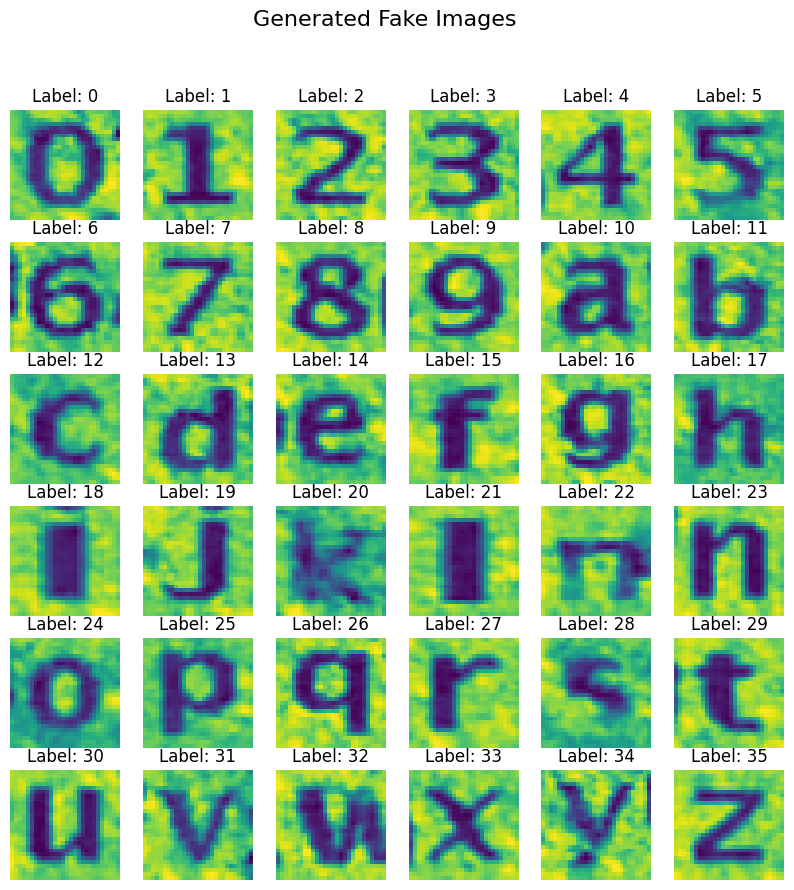

In [ ]:
[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, 36)

# Rescale pixel values from [-1, 1] to [0, 1] for plotting
X_fake = (X_fake + 1) / 2

# Plot the generated fake images with labels
plot_generated_images(X_fake, labels)

In [ ]:
# Function to plot real images
# Get a list of all subfolders (labels) in the output directory
labels = os.listdir(OUTPUT_DIR)
def plot_real_images():
    n_rows = int(np.sqrt(len(labels)))
    n_cols = len(labels) // n_rows

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    fig.suptitle("Real Images", fontsize=16)
    for i, label in enumerate(labels):
        img_files = os.listdir(os.path.join(OUTPUT_DIR, label))
        img_file = np.random.choice(img_files)
        img_path = os.path.join(OUTPUT_DIR, label, img_file)
        img = Image.open(img_path)
        axs[i // n_cols, i % n_cols].imshow(img)
        axs[i // n_cols, i % n_cols].axis("off")
        axs[i // n_cols, i % n_cols].set_title("Label: " + label)


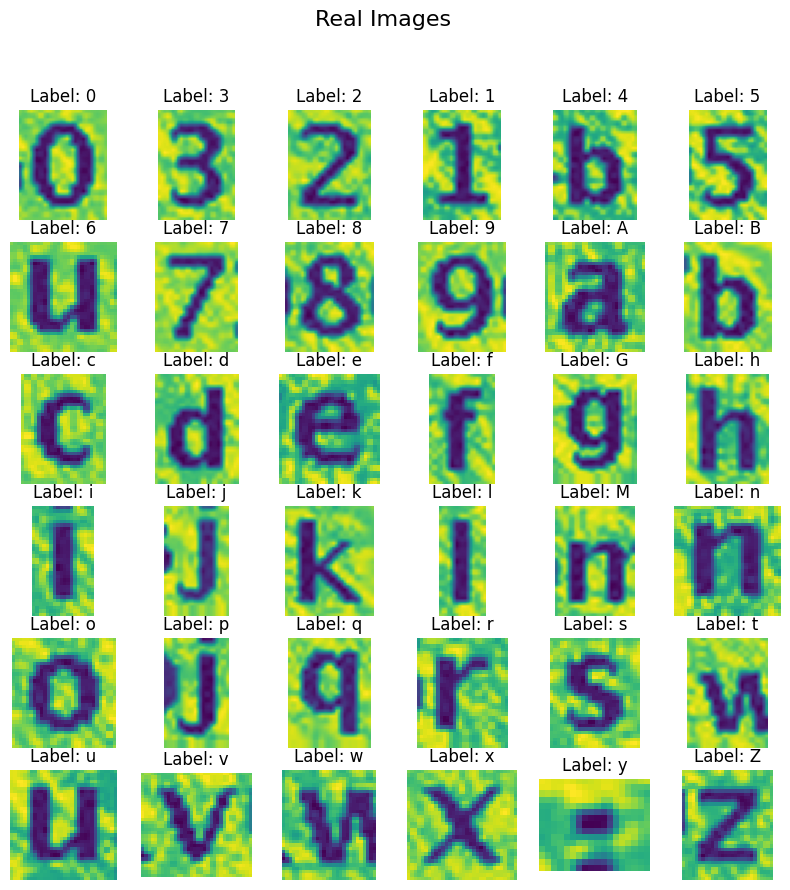

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/Colab_Notebooks/GANS/CAPTCHA/outputs"
plot_real_images()

1/1 [==============================] - 0s 27ms/step


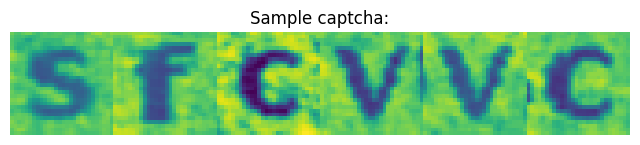

In [ ]:
def concatenate_labels(labels):
    # Assuming labels are integers
    random_labels = np.random.choice(labels, 4, replace=False)
    new_label = "".join(str(label) for label in random_labels)
    return new_label

# Generate fake samples using the generator model
[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, 16)

# Rescale pixel values from [-1, 1] to [0, 1] for plotting
X_fake = (X_fake + 1) / 2

# Concatenate 4 random labels and show the full image
concatenated_label = concatenate_labels(labels)
concatenated_images = []

for i, label in enumerate(labels):
    if str(label) in concatenated_label:
        concatenated_images.append(X_fake[i])

# Horizontally concatenate the images
concatenated_image = np.hstack(concatenated_images)

# Plot the concatenated image
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(concatenated_image)
ax.axis("off")
ax.set_title("Sample captcha:")

plt.show()

In [ ]:
# Generate fake samples using the generator model
[X_fake, generated_labels], y_fake = generate_fake_samples(g_model, latent_dim, 16)

# Use the discriminator to predict the labels for the generated fake samples
predicted_labels = d_model.predict([X_fake, generated_labels])

# Convert predicted_labels to discrete labels (0 or 1)
predicted_labels = (predicted_labels > 0.5).astype(int)

# Compare the predicted labels with the ground truth labels (y_fake)
correct_predictions = np.sum(predicted_labels == y_fake)

# Calculate the accuracy of the discriminator's predictions for the generated labels
accuracy = correct_predictions / len(y_fake)
print("Accuracy of discriminator predictions for generated labels:", accuracy)


1/1 [==============================] - 0s 19ms/step
Accuracy of discriminator predictions for generated labels: 0.6875
